# How to use Autopycoin

This notebook is a quick start for autopycoin. We will demonstrate its efficiency through a toy example.

## Import

As our package is based on tensorflow we need to import it.

In [1]:
import tensorflow as tf

Let's create our data thanks to `random_ts` which generate a fake time serie based on a trend and seasonality components.

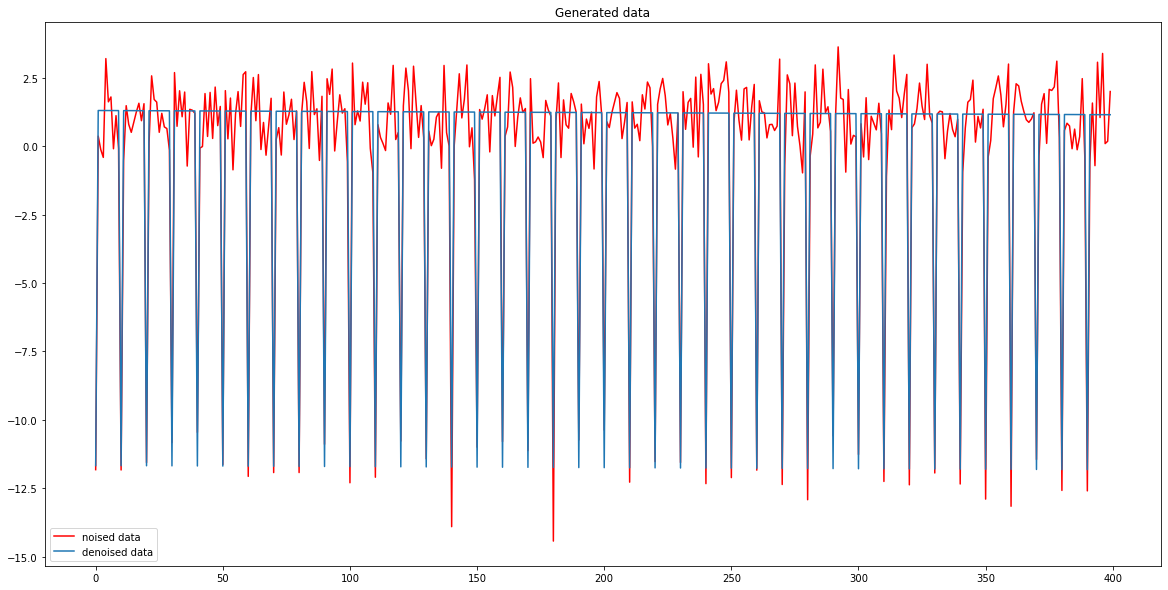

In [2]:
from autopycoin.data import random_ts

tf.random.set_seed(0)

data = random_ts(n_steps=400, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=True, # add normal centered noise
                 seed=42)

denoised_data = random_ts(n_steps=400, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=False, # add normal centered noise
                 seed=42)

# Let's render it with matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(data[0], c='r', label='noised data')
plt.plot(denoised_data[0], label='denoised data')
plt.title('Generated data')
plt.legend()

# Tensorflow library

Tensorflow use `dataset` to feed its models. Hence, we create an object `WindowGenerator` to facilitate the creation of training, validation and training set.

In [3]:
from autopycoin.dataset import WindowGenerator

We first create an instance of `Windowgenerator` by defining important parameters value.
By defining an `input_width` of 70, we set our input length.
 - `label_width` set our label length.
 - `shift` represents the shift between label and input data. Hence if you don't want label and input overlapping `shift` has to be equal to   `label_width`. It can help for more complex model like lstm models which can be trained to reconstruct their inputs.
 - `test_size` and `valid_size` are the numbers of examples to predict. If they are integer, they are the true number of examples, if they are float then it's a proportion of the entire data.

Note: We create lot of examples by shifting by one the window of prediction.

In [4]:
w = WindowGenerator(
        input_width=80,
        label_width=40,
        shift=40,
        test_size=50,
        valid_size=10,
        flat=True,
        batch_size=16,
        preprocessing = lambda x,y: (x, (x,y)) # NBEATS output
    )


We can't use it now as it needs to be initialized by an array, tensor or a dataframe

In [5]:
w = w.from_array(data=data[0], # Has to be 2D array
        input_columns=[0],
        known_columns=[],
        label_columns=[0],
        date_columns=[],)

# Or using dataframe
import pandas as pd

data = pd.DataFrame(data.numpy()[0], columns=['test'])

w = w.from_array(data=data, # Has to be 2D array
        input_columns=['test'],
        known_columns=[],
        label_columns=['test'],
        date_columns=[],)


In [6]:
w.train

<BatchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)))>

In [7]:
w.valid

<BatchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)))>

In [8]:
w.test

<BatchDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)))>

# It's time for inference

We import the nbeats module where the nbdeats model is defined.

There are currently multiple version of nbeats implemented as `create_interpretable_nbeats` or `create_generic_nbeats`.
But it is possible to customize it's own nbeats model by subclassing the nbeats Model and Layer.

In [9]:
from autopycoin.models import nbeats

model1 = nbeats.create_interpretable_nbeats(
            label_width=40,
            forecast_periods=[10],
            backcast_periods=[10],
            forecast_fourier_order=[10],
            backcast_fourier_order=[10],
            p_degree=1,
            trend_n_neurons=200,
            seasonality_n_neurons=200,
            drop_rate=0.,
            share=True)

model1.compile(tf.keras.optimizers.Adam(
    learning_rate=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), 
    loss='mse', 
    loss_weights=[1, 1], # In the paper = [0, 1]
    metrics=["mae"])

model1.fit(w.train, validation_data=w.valid, epochs=20)

Epoch 1/20
9/9 [==============================] - 19s 456ms/step - loss: 107.7595 - output_1_loss: 48.8508 - output_2_loss: 58.9087 - output_1_mae: 4.6331 - output_2_mae: 5.6065 - val_loss: 28.2610 - val_output_1_loss: 6.3400 - val_output_2_loss: 21.9210 - val_output_1_mae: 2.0182 - val_output_2_mae: 3.4445
Epoch 2/20
9/9 [==============================] - 0s 31ms/step - loss: 17.0173 - output_1_loss: 5.0084 - output_2_loss: 12.0089 - output_1_mae: 1.7634 - output_2_mae: 2.6280 - val_loss: 9.0327 - val_output_1_loss: 3.2561 - val_output_2_loss: 5.7766 - val_output_1_mae: 1.4348 - val_output_2_mae: 1.9232
Epoch 3/20
9/9 [==============================] - 0s 32ms/step - loss: 7.7175 - output_1_loss: 2.6491 - output_2_loss: 5.0685 - output_1_mae: 1.2985 - output_2_mae: 1.7502 - val_loss: 4.7811 - val_output_1_loss: 1.9094 - val_output_2_loss: 2.8717 - val_output_1_mae: 1.1005 - val_output_2_mae: 1.3431
Epoch 4/20
9/9 [==============================] - 0s 33ms/step - loss: 4.4976 - output_

In [10]:
from autopycoin.models import nbeats

model2 = nbeats.create_generic_nbeats(
            label_width=40,
            g_forecast_neurons=16, 
            g_backcast_neurons=16, 
            n_neurons=16, 
            n_blocks=3,
            n_stacks=2,
            drop_rate=0.1,
            share=True)

model2.compile(tf.keras.optimizers.Adam(
    learning_rate=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss='mse', 
    loss_weights=[1, 1], # In the paper = [0, 1]
    metrics=["mae"])

model2.fit(w.train, validation_data=w.valid, epochs=20)

Epoch 1/20
9/9 [==============================] - 13s 355ms/step - loss: 42.6128 - output_1_loss: 20.5989 - output_2_loss: 22.0138 - output_1_mae: 2.9896 - output_2_mae: 3.3102 - val_loss: 35.9356 - val_output_1_loss: 17.8830 - val_output_2_loss: 18.0526 - val_output_1_mae: 2.7465 - val_output_2_mae: 2.8812
Epoch 2/20
9/9 [==============================] - 0s 47ms/step - loss: 33.6867 - output_1_loss: 16.9436 - output_2_loss: 16.7431 - output_1_mae: 2.5379 - output_2_mae: 2.6609 - val_loss: 32.3713 - val_output_1_loss: 16.0248 - val_output_2_loss: 16.3464 - val_output_1_mae: 2.5090 - val_output_2_mae: 2.4740
Epoch 3/20
9/9 [==============================] - 0s 49ms/step - loss: 31.6279 - output_1_loss: 16.0887 - output_2_loss: 15.5393 - output_1_mae: 2.4137 - output_2_mae: 2.4602 - val_loss: 31.0422 - val_output_1_loss: 15.9003 - val_output_2_loss: 15.1419 - val_output_1_mae: 2.4889 - val_output_2_mae: 2.3757
Epoch 4/20
9/9 [==============================] - 0s 44ms/step - loss: 30.715

# Evaluation

In [11]:
model1.evaluate(w.test)

4/4 [==============================] - 0s 18ms/step - loss: 2.6927 - output_1_loss: 1.2548 - output_2_loss: 1.4379 - output_1_mae: 0.8934 - output_2_mae: 0.9630


[2.692697048187256,
 1.2548267841339111,
 1.4378703832626343,
 0.8934133052825928,
 0.9630153179168701]

In [12]:
model2.evaluate(w.test)

4/4 [==============================] - 0s 22ms/step - loss: 10.9378 - output_1_loss: 5.5514 - output_2_loss: 5.3864 - output_1_mae: 1.7609 - output_2_mae: 1.6672


[10.937788963317871,
 5.551424503326416,
 5.386363506317139,
 1.7609360218048096,
 1.66715669631958]

# Plot

Let plot some previsions

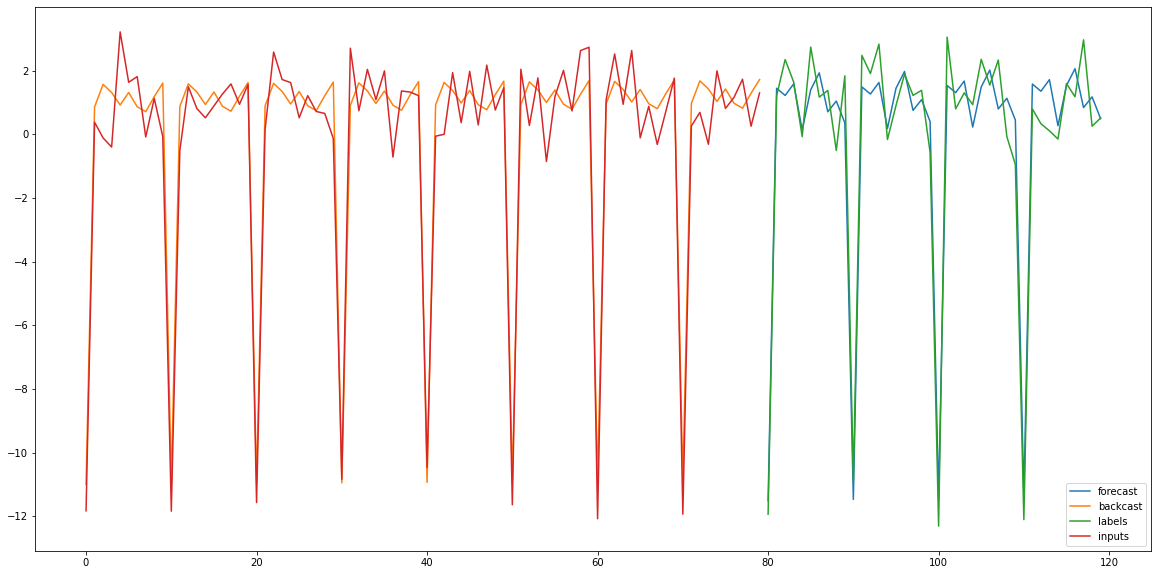

In [13]:
import matplotlib.pyplot as plt

iterator = iter(w.train)
x, y = iterator.get_next()

input_width = 80

plt.plot(range(input_width, input_width + 40), model1.predict(x)[1].values[0], label='forecast')
# Usefull only if stack = True
plt.plot(range(input_width), model1.predict(x)[0].values[0], label='backcast')
plt.plot(range(input_width, input_width + 40), y[1][0], label='labels')
plt.plot(range(input_width), x[0], label='inputs')
plt.legend()

# Production

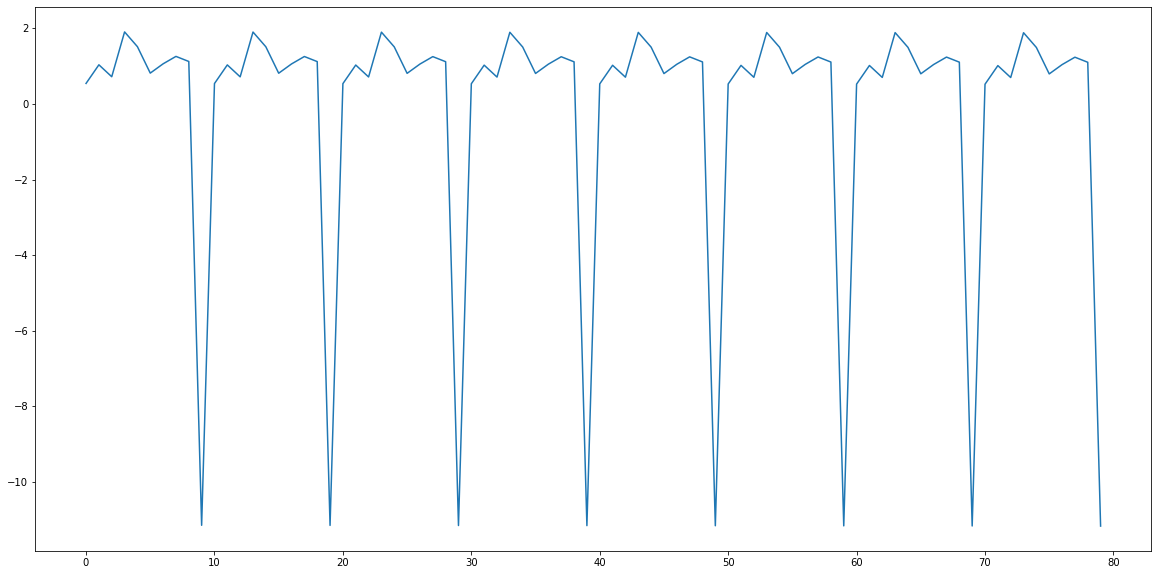

In [14]:
prod = w.production(data)
plt.plot(model1.predict(prod)[0].values[1])

# A pool is better than a single model

Generally, a pool is better than a single model : It is a regularization method.
In this toy example, it won't because we are not optimizing the training phase.

In [15]:
from autopycoin.models import PoolNBEATS

# Create a callable which define label_width and create a Tensorflow Model.
model = lambda label_width: nbeats.create_interpretable_nbeats(
            label_width=label_width,
            forecast_periods=[10],
            backcast_periods=[10],
            forecast_fourier_order=[10],
            backcast_fourier_order=[10],
            p_degree=1,
            trend_n_neurons=200,
            seasonality_n_neurons=200,
            drop_rate=0.,
            share=True)

# Define an aggregation method with fn_agg, the number of models with n_models and the 
# label width with label_width. label_width is mandatory if you use callables in nbeats_models !
model = PoolNBEATS(n_models=3, label_width=40, nbeats_models=model,
            fn_agg=tf.reduce_mean)

model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss=['mse', 'mse'], metrics=['mae'])

# The fit is printing 6 different maes results: 2 for each model (backcast, forecast).
# The loss is aggregated then it is printing 4 loss results: 1 for the entire model, 
model.fit(w.train, validation_data=w.valid, epochs=20)

Epoch 1/20
9/9 [==============================] - 53s 804ms/step - loss: 57.5827 - output_1_1_loss: 14.6124 - output_1_2_loss: 24.6199 - output_2_1_loss: 18.3504 - output_1_1_mae: 2.9415 - output_1_2_mae: 3.6889 - output_2_1_mae: 3.2134 - output_2_2_mae: 4.0851 - output_3_1_mae: 3.1088 - output_3_2_mae: 3.6205 - val_loss: 24.5379 - val_output_1_1_loss: 6.3383 - val_output_1_2_loss: 11.3736 - val_output_2_1_loss: 6.8260 - val_output_1_1_mae: 2.0681 - val_output_1_2_mae: 2.6568 - val_output_2_1_mae: 2.1357 - val_output_2_2_mae: 3.0742 - val_output_3_1_mae: 1.9745 - val_output_3_2_mae: 2.6875
Epoch 2/20
9/9 [==============================] - 1s 74ms/step - loss: 16.5498 - output_1_1_loss: 4.1335 - output_1_2_loss: 7.2741 - output_2_1_loss: 5.1422 - output_1_1_mae: 1.6115 - output_1_2_mae: 2.0738 - output_2_1_mae: 1.7942 - output_2_2_mae: 2.3740 - output_3_1_mae: 1.5195 - output_3_2_mae: 2.1187 - val_loss: 11.5024 - val_output_1_1_loss: 2.8091 - val_output_1_2_loss: 4.6362 - val_output_2_1

Epoch 15/20
9/9 [==============================] - 1s 79ms/step - loss: 2.7738 - output_1_1_loss: 0.8466 - output_1_2_loss: 0.8917 - output_2_1_loss: 1.0354 - output_1_1_mae: 0.7357 - output_1_2_mae: 0.7573 - output_2_1_mae: 0.8246 - output_2_2_mae: 0.8072 - output_3_1_mae: 0.8107 - output_3_2_mae: 0.7608 - val_loss: 3.3156 - val_output_1_1_loss: 0.7747 - val_output_1_2_loss: 1.6801 - val_output_2_1_loss: 0.8607 - val_output_1_1_mae: 0.7123 - val_output_1_2_mae: 1.0399 - val_output_2_1_mae: 0.7588 - val_output_2_2_mae: 1.0080 - val_output_3_1_mae: 0.7535 - val_output_3_2_mae: 1.1122
Epoch 16/20
9/9 [==============================] - 1s 78ms/step - loss: 2.7374 - output_1_1_loss: 0.8410 - output_1_2_loss: 0.8752 - output_2_1_loss: 1.0212 - output_1_1_mae: 0.7335 - output_1_2_mae: 0.7508 - output_2_1_mae: 0.8191 - output_2_2_mae: 0.7880 - output_3_1_mae: 0.8070 - output_3_2_mae: 0.7511 - val_loss: 3.2870 - val_output_1_1_loss: 0.7727 - val_output_1_2_loss: 1.6718 - val_output_2_1_loss: 0

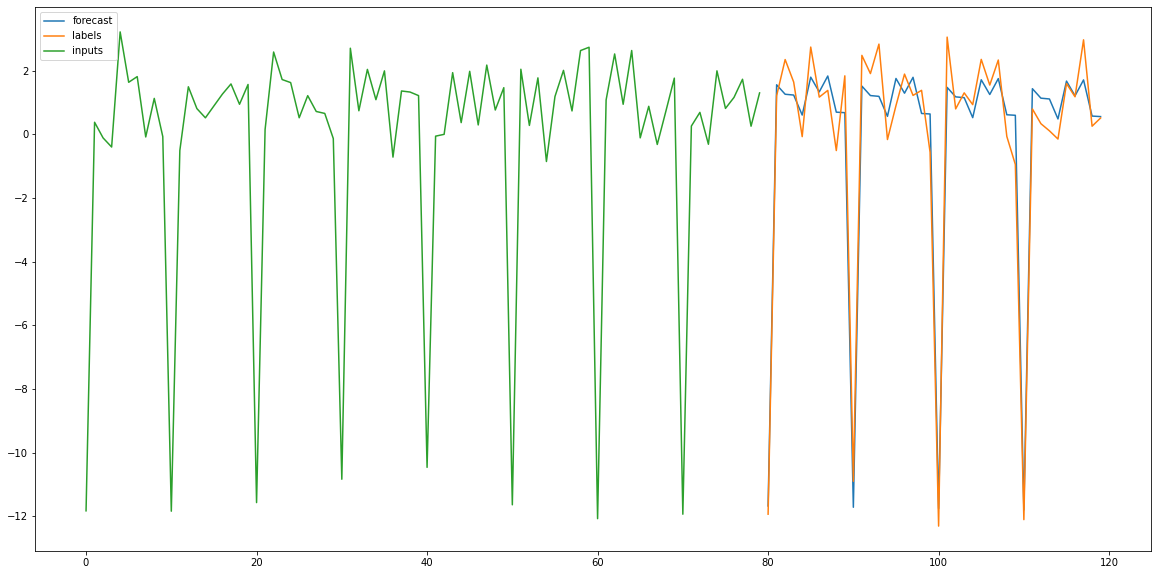

In [16]:
import matplotlib.pyplot as plt

iterator = iter(w.train)
x, y = iterator.get_next()

input_width = 80

plt.plot(range(input_width, input_width + 40), model.predict(x)[1][0], label='forecast')
plt.plot(range(input_width, input_width + 40), y[1][0], label='labels')
plt.plot(range(input_width), x[0], label='inputs')
plt.legend()